In [2]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
import scipy.signal as sig

from IPython.display import display
from IPython.core.pylabtools import figsize, getfigs
from pyteomics import mzml, auxiliary

smallfile = '/home/gama/local/pmi/data/Mass Spectra/iPRG2012/prg.ms1.selectmz.selectidx.mzML'
smallmz   = mzml.read(smallfile, use_index=True)

In [3]:
filename  = '/home/gama/local/pmi/data/Mass Spectra/iPRG2012/prg.ms1.mzML'
mzfile    = mzml.read(filename, use_index=True)

In [8]:
smallmz[15]

{'index': 15,
 'id': 'sample=1 period=1 cycle=3016 experiment=1',
 'defaultArrayLength': 49738,
 'scanList': {'count': 1,
  'scan': [{'scanWindowList': {'count': 1,
     'scanWindow': [{'scan window lower limit': 400.0 m/z,
       'scan window upper limit': 1250.0 m/z}]},
    'scan start time': 55.65995 minute,
    'preset scan configuration': 1.0}],
  'no combination': ''},
 'ms level': 1,
 'MS1 spectrum': '',
 'positive scan': '',
 'profile spectrum': '',
 'base peak intensity': 1815.0 number of detector counts,
 'base peak m/z': 621.796292306591 m/z,
 'total ion current': 1293185.0 number of detector counts,
 'count': 2,
 'm/z array': array([400.16986, 400.17267, 400.1755 , ..., 709.992  , 709.9957 ,
        709.9995 ], dtype=float32),
 'intensity array': array([ 5.,  5.,  0., ..., 16., 22., 11.], dtype=float32)}

In [2]:
smallmz.reset()
ion_counts = np.array([s['total ion current'] for s in smallmz])
ion_counts.shape

(1001,)

In [3]:
%timeit [smallmz[i]['base peak intensity'] for i in range(len(smallmz))]

3.57 s ± 285 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [36]:
def x():
    smallmz.reset();
    return sum([s['base peak intensity'] for s in smallmz])
 

In [4]:
display(np.argsort(ion_counts)[:5])
display(np.argsort(ion_counts)[-5:])

array([952, 954, 943, 951, 946])

array([116, 117, 113, 114, 115])

In [5]:
max_ion_count_indexes = np.argsort(ion_counts)[-5:]
ion_counts[max_ion_count_indexes]

array([2838783., 2896221., 3060348., 3104588., 3115233.])

In [42]:
smallmz[int(max_ion_count_indexes[-1])]

{'index': 115,
 'id': 'sample=1 period=1 cycle=3116 experiment=1',
 'defaultArrayLength': 21107,
 'scanList': {'count': 1,
  'scan': [{'scanWindowList': {'count': 1,
     'scanWindow': [{'scan window lower limit': 400.0 m/z,
       'scan window upper limit': 1250.0 m/z}]},
    'scan start time': 58.053966666667 minute,
    'preset scan configuration': 1.0}],
  'no combination': ''},
 'ms level': 1,
 'MS1 spectrum': '',
 'positive scan': '',
 'profile spectrum': '',
 'base peak intensity': 19112.0 number of detector counts,
 'base peak m/z': 621.095805766355 m/z,
 'total ion current': 3115233.0 number of detector counts,
 'count': 2,
 'm/z array': array([400.13876, 400.1416 , 400.1529 , ..., 709.9807 , 709.9957 ,
        709.9995 ], dtype=float32),
 'intensity array': array([46.,  0.,  0., ...,  0.,  0., 46.], dtype=float32)}

In [43]:
type(smallmz)

pyteomics.mzml.MzML

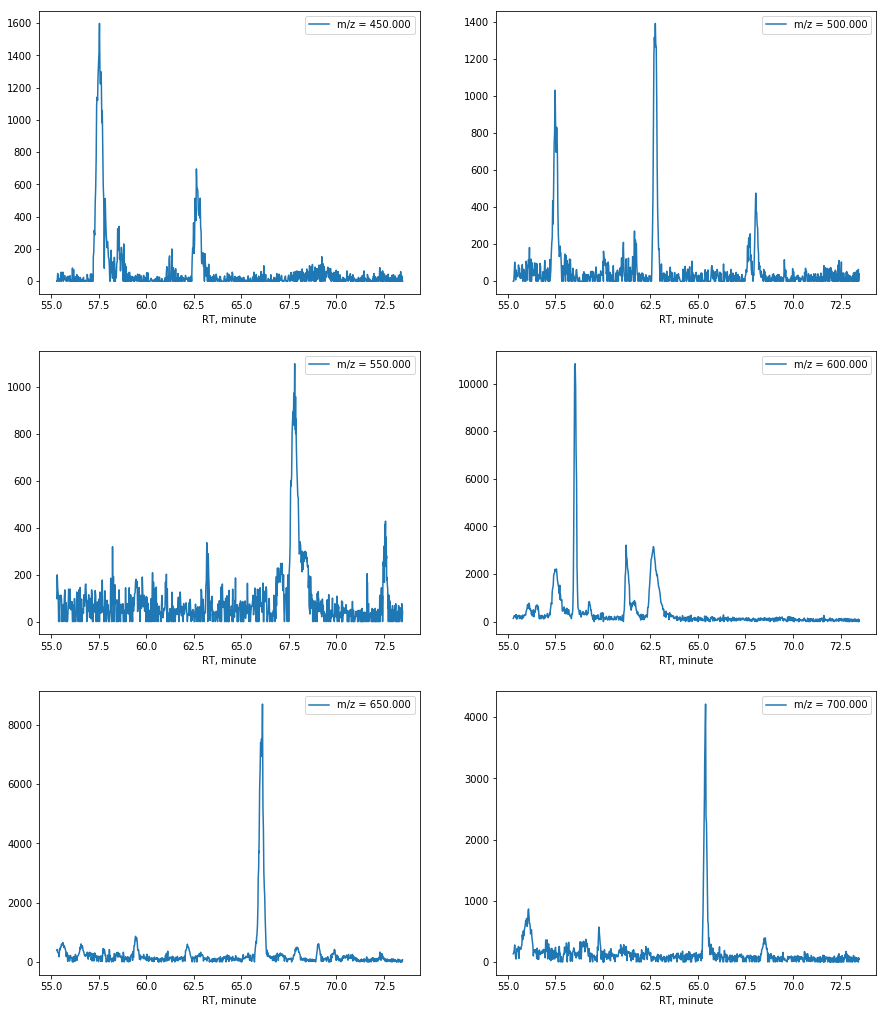

In [31]:
def plot_xic(spectra, mzs, tolerance = 0.05):
    rts     = [[] for mz in mzs]
    intenss = [[] for mz in mzs]
    for scan in spectra:
        if scan['ms level'] == 1:
            for (mz, rt, intens,) in zip(mzs, rts, intenss):
                i = scan['m/z array'].searchsorted(mz - tolerance)
                j = scan['m/z array'].searchsorted(mz + tolerance)
                rt.append(scan['scanList']['scan'][0]['scan start time'])
                intens.append(scan['intensity array'][i:j].sum())
            
    nrows = int(len(mzs) / 2) + 1
    fig   = plt.figure(figsize=(15, 6 * nrows,))
    for (i, (mz, rt, intens),) in enumerate(zip(mzs, rts, intenss)):
        ax = fig.add_subplot(nrows, 2, i + 1)
        ax.plot(rt, intens, label='m/z = {:.3f}'.format(mz))
        ax.set_xlabel('RT, ' + rt[0].unit_info)
        ax.legend()
    
smallmz.reset()
plot_xic(smallmz, [450, 500, 550, 600, 650, 700])

In [32]:
def plot_hightest_peaks(spectra, mzs, tolerance = 0.05):
    rts     = [[] for mz in mzs]
    intenss = [[] for mz in mzs]
    for scan in spectra:
        if scan['ms level'] == 1:
            for (mz, rt, intens,) in zip(mzs, rts, intenss):
                i = scan['m/z array'].searchsorted(mz - tolerance)
                j = scan['m/z array'].searchsorted(mz + tolerance)
                rt.append(scan['scanList']['scan'][0]['scan start time'])
                intens.append(scan['intensity array'][i:j].sum())
            
    nrows = int(len(mzs) / 2) + 1
    fig   = plt.figure(figsize=(15, 6 * nrows,))
    for (i, (mz, rt, intens),) in enumerate(zip(mzs, rts, intenss)):
        ax = fig.add_subplot(nrows, 2, i + 1)
        ax.plot(rt, intens, label='m/z = {:.3f}'.format(mz))
        ax.set_xlabel('RT, ' + rt[0].unit_info)
        ax.legend()
    


In [5]:
# scan = smallmz[0]
# scan['scanList']['scan']

# scan = mzfile[6000]
# scan

smallmz.reset()
smallmz_high_ions_idx = [scan['index'] for scan in smallmz if scan['base peak intensity'] > 10000]
len(smallmz_high_ions_idx)

138

In [6]:
mzfile.reset()
mzfile_high_ions_idx = [scan['index'] for scan in mzfile if scan['base peak intensity'] > 10000]
len(mzfile_high_ions_idx)

1640

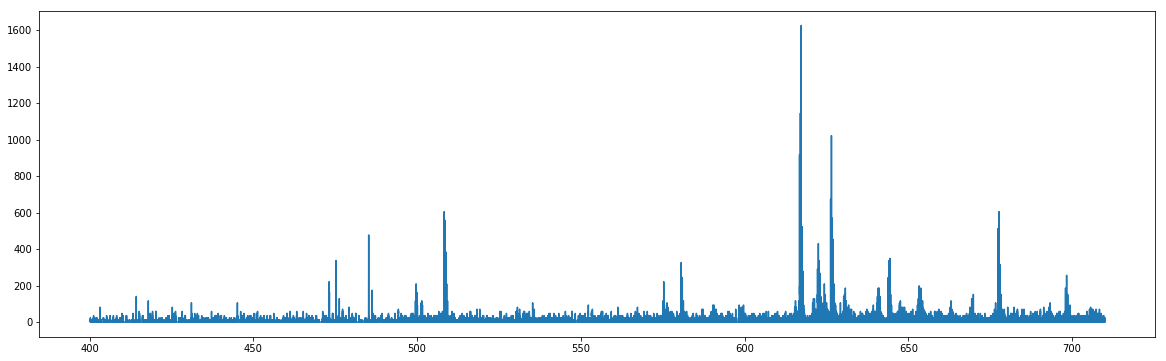

In [23]:
scan = smallmz.time[60]
scan['intensity array']
fig = plt.figure(figsize(20, 6,))
plt.plot(scan['m/z array'], scan['intensity array'])

In [188]:
peak_idxs, props = sig.find_peaks(scan['intensity array'], height=500)
# len(peak_idxs)
list(zip(scan['m/z array'][peak_idxs], props['peak_heights']))

14

<Figure size 1440x432 with 0 Axes>

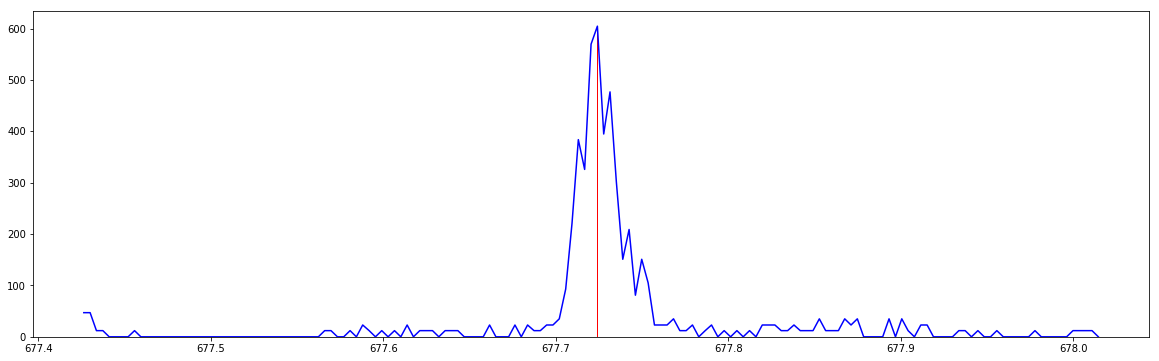

In [189]:
l, u = 13, 14
mz_peaks     = scan['m/z array'][peak_idxs[l:u]]
intens_peaks = scan['intensity array'][peak_idxs[l:u]]
fig          = plt.figure(figsize=(20, 6,))
xpixels      = fig.get_size_inches()[0] * fig.get_dpi()
width        = np.ptp(mz_peaks) / xpixels
fig = plt.figure(figsize=(20, 6,))
ax  = fig.add_subplot(111)
# ax.set_xmax = np.amax(scan['m/z array'])
# ax.set_xmin = np.amin(scan['m/z array'])

for peak_mz in mz_peaks:
    i = scan['m/z array'].searchsorted(peak_mz - 0.3)
    j = scan['m/z array'].searchsorted(peak_mz + 0.3)
    mzs     = scan['m/z array'][i:j]
    intenss = scan['intensity array'][i:j]
    ax.plot(mzs, intenss, color='b')
    
ax.bar(mz_peaks, intens_peaks, width=0.001, color='r')
None

In [244]:
# window3 = sig.savgol_coeffs(17, 13, use='conv')
# window2 = sig.savgol_coeffs(17, 2, use='conv')
# plt.plot(list(range(len(window3))), window3, window2)

# window1 = sig.gaussian(101, std=10)
# window2 = sig.gaussian(201, std=20)
# plt.plot(window1)
# plt.plot(window2)

arr  = np.array([1, 2, 3, 4, 3, 2, 1, 2, 3, 4, 5, 6, 5, 3, 1, 2, 0])
idx, = sig.argrelmax(arr)
idx, arr[idx]

(array([ 3, 11, 15]), array([4, 6, 2]))

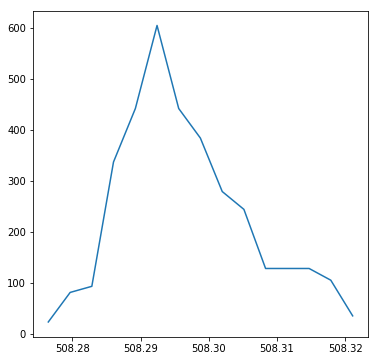

In [288]:
mzs         = scan['m/z array']
intenss     = scan['intensity array']
peak_idx    = peak_idxs[0]
window_size = 40
peak_ratio  = 0.05
thresh      = intenss[peak_idx] * peak_ratio

lbound_neighbor = next(idx
    for idx in range(peak_idx, peak_idx - window_size, -1)
    if intenss[idx] < thresh
)
ubound_neighbor = next(idx
    for idx in range(peak_idx, peak_idx + window_size, 1)
    if intenss[idx] < thresh
)
lbound_neighbor, mzs[lbound_neighbor], ubound_neighbor, mzs[ubound_neighbor]

plt.figure(figsize=(6, 6,))
plt.plot(mzs[lbound_neighbor:ubound_neighbor], intenss[lbound_neighbor:ubound_neighbor])
None

In [298]:
hw_ratio1  = intenss[peak_idx] / (2 * max(peak_idx - lbound_neighbor, ubound_neighbor - peak_idx))
hw_ratio2  = intenss[peak_idx] / (ubound_neighbor - lbound_neighbor)
skew_ratio = abs((peak_idx - lbound_neighbor) - (ubound_neighbor - peak_idx)) / intenss[peak_idx]
hw_ratio1, hw_ratio2, skew_ratio

(30.25, 40.333333333333336, 0.008264462809917356)

NameError: name 'mzpeaks' is not defined